# 이미지 분류
- https://www.tensorflow.org/tutorials/images/classification?hl=ko


preprocessing.image_dataset_from_directory: 디스크에서 데이터 세트를 효율적으로 로드

기본적인 ML 워크플로우
1. 데이터 검토 및 이해
2. 입력 파이프 라인 구축
3. 모델 구축
4. 모델 훈련
5. 모델 테스트
6. 모델을 개선하고 프로세스를 반복하십시오.

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import os 
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib 

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir) # 하위 디렉토리 하나당 하나의 클래스

In [9]:
image_path_list = list(data_dir.glob('*/*.jpg'))
image_count = len(image_path_list) 
# 예: PosixPath('/Users/wonji/.keras/datasets/flower_photos/roses/16209331331_343c899d38.jpg')

/Users/wonji/.keras/datasets/flower_photos/roses/16209331331_343c899d38.jpg


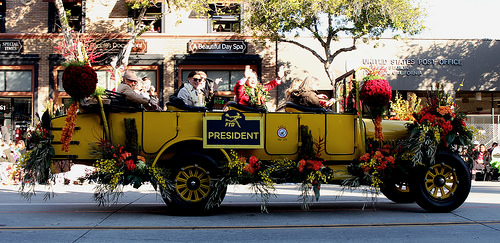

In [12]:
print(image_path_list[0])
PIL.Image.open(image_path_list[0])

In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
class_names = train_ds.class_names # 하위 디렉토리 = 클래스 -> 자동으로 클래스 매핑

In [17]:
train_ds.take(1)

<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [18]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [20]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [21]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 
# use buffered prefetching so you can yield data from disk without having I/O become blocking
# prefetch: 프로세서가 원래 메모리 -> 빠른 로컬 메모리로 미리 옮겨놓아 성능을 높이는 것
# 파이프라인이 데이터를 가져오는 동안 모델이 유휴 상태 -> 이 시간을 단축하기 위함 (https://ahnjg.tistory.com/32)
# AUTOTUNE: 동적으로 조정해줌 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255) # RGB -> input value를 작게 하는게 NN에 유리

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [26]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # normalization
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.summary()

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              # from_logits이란? https://hwiyong.tistory.com/335 
              metrics=['accuracy'])

model.summary() # compile 여부와 무관하게 모델 형태 정해졌으면 알 수 있음

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [27]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)    

Epoch 1/10
92/92 [==============================] - 31s 326ms/step - loss: 1.5199 - accuracy: 0.3367 - val_loss: 1.0730 - val_accuracy: 0.5668
Epoch 2/10
92/92 [==============================] - 28s 299ms/step - loss: 1.0053 - accuracy: 0.6000 - val_loss: 0.9755 - val_accuracy: 0.6104
Epoch 3/10
92/92 [==============================] - 27s 297ms/step - loss: 0.7932 - accuracy: 0.7110 - val_loss: 0.8958 - val_accuracy: 0.6621
Epoch 4/10
92/92 [==============================] - 27s 296ms/step - loss: 0.5875 - accuracy: 0.7902 - val_loss: 0.8897 - val_accuracy: 0.6662
Epoch 5/10
92/92 [==============================] - 27s 298ms/step - loss: 0.3471 - accuracy: 0.8873 - val_loss: 1.0670 - val_accuracy: 0.6172
Epoch 6/10
92/92 [==============================] - 28s 306ms/step - loss: 0.2227 - accuracy: 0.9325 - val_loss: 1.2022 - val_accuracy: 0.6594
Epoch 7/10
92/92 [==============================] - 29s 315ms/step - loss: 0.1015 - accuracy: 0.9718 - val_loss: 1.4645 - val_accuracy: 0.6444

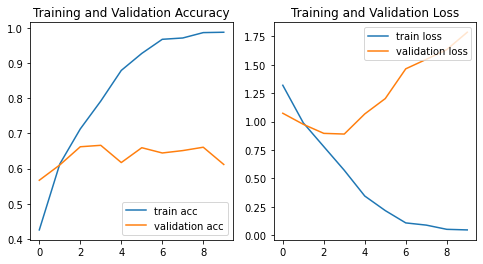

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='validation acc')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# overfitting 개선안: 1) data augmentation, 2) Dropout layer

In [31]:
# 1) data augmentation: 데이터 추가 layers from tf.keras.layers.experimental.preprocessing.
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1), 
    layers.experimental.preprocessing.RandomZoom(0.1)
])

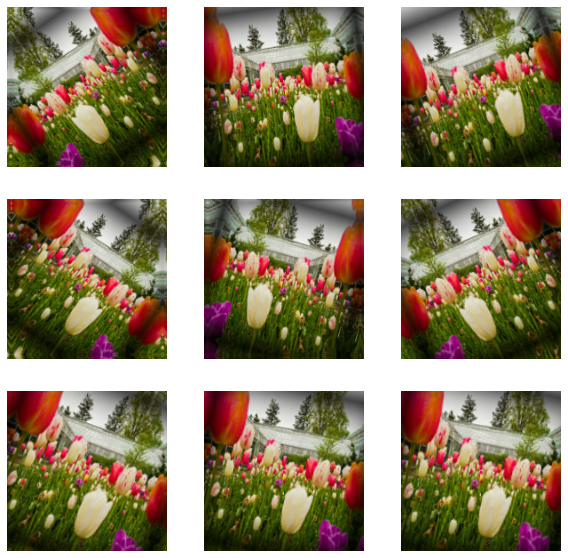

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [36]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),  
    layers.Dropout(0.2), # 드롭아웃 레이어 추가
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [39]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 33s 354ms/step - loss: 1.3957 - accuracy: 0.3981 - val_loss: 1.2336 - val_accuracy: 0.4837
Epoch 2/15
92/92 [==============================] - 32s 347ms/step - loss: 1.0374 - accuracy: 0.5871 - val_loss: 0.9468 - val_accuracy: 0.6471
Epoch 3/15
92/92 [==============================] - 32s 345ms/step - loss: 0.9093 - accuracy: 0.6284 - val_loss: 0.9056 - val_accuracy: 0.6349
Epoch 4/15
92/92 [==============================] - 34s 370ms/step - loss: 0.8528 - accuracy: 0.6652 - val_loss: 0.8183 - val_accuracy: 0.6785
Epoch 5/15
92/92 [==============================] - 33s 364ms/step - loss: 0.7909 - accuracy: 0.6929 - val_loss: 0.8273 - val_accuracy: 0.6785
Epoch 6/15
92/92 [==============================] - 34s 366ms/step - loss: 0.7424 - accuracy: 0.7146 - val_loss: 0.8122 - val_accuracy: 0.6907
Epoch 7/15
92/92 [==============================] - 33s 362ms/step - loss: 0.7052 - accuracy: 0.7255 - val_loss: 0.8445 - val_accuracy: 0.6730

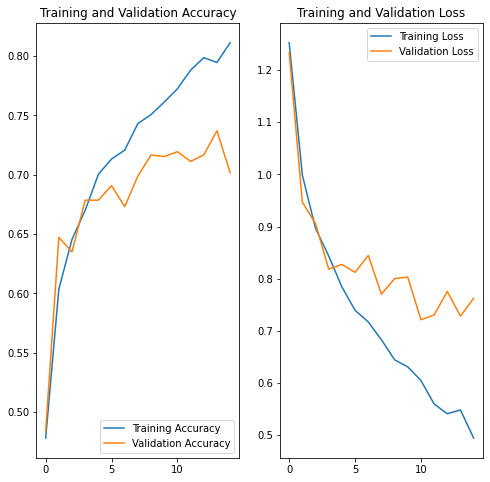

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
# ** Data augmentation and Dropout layers are inactive at inference time
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to sunflowers with a 96.65 percent confidence.
